# Entrenamiento evolutivo de redes neuronales para regresión

### Descripción

<font size="4"> Algoritmo evolutivo para entrenar una red neuronal de una sola capa para regresión de datos (minimización).
 
### Componentes
   
-<font size="3"> La evaluación de individuos implementa la fase forward de un multi-layer perceptron con los pesos y sesgos de la red neuronal.
    
- <font size="3"> Datos:
    
    - <font size="3"> Regresión

    - <font size="3"> Entradas numéricas y categóricas
        
- <font size="3"> Algoritmo evolutivo:
    
    - <font size="3"> Representación real de los pesos y sesgos de la red neuronal
    
    - <font size="3"> Selección por ranking (lineal, no lineal, exponencial) 

    - <font size="3"> Muestreo estocástico con reemplazamiento

    - <font size="3"> Sustitución generacional completa

    - <font size="3"> Elitista

    - <font size="3"> Cruce uniforme, aritmético y SBX

    - <font size="3"> Mutación uniforme, 'small' y polinomial
    
### Notas de implementación

- <font size="3"> El ranking lineal y exponencial se ha implementado como aparece en: ${\it \small\mbox{Tobias Blickle and Lothar Thiele (1995), A Comparison of Selection Schemes used in Genetic Algorithms}}$, modificado para tratar poblaciones ordenadas de mejor a peor.

- <font size="3"> El ranking no lineal se ha implementado como aparece en: ${\it \small \mbox{Zbigniew Michalewicz (1996), Genetic Algorithms + Data Structures = Evolution Programs}}$
    
### Comentarios adicionales
    
- <font size="3"> Se requiere ordenar la población.
    
- <font size="3"> Se puede controlar la presión selectiva.    

- <font size="3"> Se leen los datos en formato arff.
    
- <font size="3"> Se imputan los missing values con la media (atributos numéricos) o la moda (atributos categóricos).
    
- <font size="3"> Los atributos de entrada categóricos se transforman a atributos binarios con one hot encoding.
    
- <font size="3"> Los datos de entrada y la salida se convierten en arrays numpy para mayor eficiencia en los cálculos.
    
---

### Requerimientos

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold,RepeatedKFold

### Lectura de los datos
#### Input:
  - $file\_path$: Nombre completo con path de la base de datos .arff a cargar
  
#### Output:
  - $X$: Atributos de entrada numéricos y categóricos
  - $y$: Salida numérica

In [2]:
def LoadData(file_path):

    data, meta = arff.loadarff(file_path)

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Separar atributos numéricos y categóricos
    numeric_attributes = df.iloc[:, :-1] .select_dtypes(include=['int', 'float']).columns
    categorical_attributes =  df.iloc[:, :-1].select_dtypes(include=['object']).columns
    
    # Imputación para atributos numéricos
    if numeric_attributes.size>0:
        df[numeric_attributes] = SimpleImputer(strategy='mean').fit_transform(df[numeric_attributes])
        
    # Imputación para atributos categóricos
    # Aplicar hot encoding
    if categorical_attributes.size>0:
        df[categorical_attributes] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_attributes])
        X = pd.get_dummies(data=df.iloc[:, :-1], columns=categorical_attributes)    
        X = X.astype(float)
    else:
        X = df.iloc[:, :-1]    
    
    # Salida: y
    y = df.iloc[:, -1] 
        
    # Convertir las entradas y salidas en arrays numpy
    X = np.array(X)
    y = np.array(y)    
            
    return X,y

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $random\_state$: Semilla para reproducibilidad
- $X,y$: Datos
- $prob$: Probabilidades
  - $prob\_cross$: Probabilidades de cruce
    - $p\_c$: Probabilidad de cruce
    - $uniform\_crossover\_probability$: Probabilidad de cruce uniforme
    - $arithmetic\_crossover\_probability$: Probabilidad de cruce aritmético
    - $SBX\_crossover\_probability$: Probabilidad de cruce SBX
  - $prob\_mutation$: Probabilidades de mutación
    - $p\_m$: Probabilidad de mutación
    - $uniform\_mutation\_probability$: Probabilidad de mutación uniforme 
    - $small\_mutation\_probability$: Probabilidad de mutación small 
    - $polynomial\_mutation\_probability$: Probabilidad de mutación small 
    - $epsilon$: Máximo cambio en mutación small
- $param$: Parámetros del ranking:
  - $amin$: Número esperado  de descendientes del peor individuo para selección por ranking lineal
  - $amax$:  Número esperado de descendientes del mejor individuo para selección por ranking lineal ($1<=amax<=2$)
  - $q$: Presión selectiva en ranking no lineal de Michalewicz, alto es más presión
  - $c$: Presión selectiva en ranking exponencial, bajo es más presión
  - $rank\_type$: Tipo de ranking: 'linear', 'nonlinear', 'exponential'

In [3]:
G = 100
N = 100
random_state = 1

file_path = 'ICU_train.arff' # Atributos numéricos y categóricos

X,y = LoadData(file_path)

p_c = 0.7
uniform_crossover_probability = 0.4 
arithmetic_crossover_probability = 0.2
SBX_crossover_probability = 0.4

p_m = 0.1
uniform_mutation_probability = 0.4
small_mutation_probability = 0.2
polynomial_mutation_probability = 0.4
epsilon = 1e-6

prob_cross = p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability
prob_mutation = p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon
prob = prob_cross,prob_mutation

amin = 0
amax = 2-amin
q = 0.7
c = 0.3
rank_type = 'exponential'

param = amin,amax,q,c,rank_type

### Definición del problema de optimización
- $L$: Límite inferior de los pesos y sesgos
- $U$: Límite superior de los pesos y sesgos
- $p$: Número de variables de decisión (número de pesos y sesgos de la red neuronal)
- $f$: Función objetivo

$\textit{Minimizar} \ f(\textbf{x})= MSE(\textbf{x}, D,\Phi)$
- $\textbf{x}$: Vector de variables de decisión que representa a la red neuronal
- $D = (X,y)$: Conjunto de datos
- $\Phi$: Algoritmo de aprendizaje: Red neuronal representada por $\textbf{x}$

#### Arquitectura de la red neuronal
- $n$: Número de entradas a la red neuronal (número de atributos de entrada del conjunto de datos)
- $m$: Número de neuronas de la capa oculta
- $s$: Número de clases del atributo de salida del conjunto de datos

In [4]:
def NN(X,y):
    n = len(X.T)
    m = 10 
    s = 1
    
    p = (n * m) + m + (m * s) + s # número de variables de decisión
    L = np.full(p, -3.5)
    U = np.full(p,  3.5)
    
    return n,m,s,p,L,U

def prediction_function(solution,X):
    
    W1,b1,W2,b2 = solution
    
    # Perform forward propagation
    
    # Pre-activation in Layer 1
    P = X.dot(W1) + b1                
    
    # Activation in Layer 1     
    X = np.tanh(P)                        # Tangente hiperbólica (appropriate for RNN or MLP)
    # X = np.maximum(P, 0)                # Relu (appropriate for MLP or CNN)
    # X = np.maximum(0.01*P,P)            # Leaky Relu (appropriate for RNN or CNN)
    # X = 1.0 / (1.0 + np.exp(-P))        # sigmoide (appropriate for RNN)
    
    # Pre-activation in Layer 2
    L = X.dot(W2) + b2           
    
    return L                              # outputs for Layer 2

def reshape(x,nn):

    n,m,s,p,L,U = nn
    
    n1 = n*m
    n2 = n1 + m
    n3 = n2 + m*s
    
    # Roll-back the weights and biases
    W1 = x[0:n1].reshape((n,m))
    b1 = x[n1:n2].reshape((m,))
    W2 = x[n2:n3].reshape((m,s))   
    b2 = x[n3:p].reshape((s,))
    
    return W1,b1,W2,b2

def f(x,nn,X,y):
    solution = reshape(x,nn)    
    y_pred = prediction_function(solution,X)
    return mean_squared_error(y,y_pred)


### Definición de individuo

In [5]:
class Individuo:
    def __init__(self,p):
        self.x = np.zeros(p)
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [6]:
def InitializePopulation(P,L,U):
    n = L.size
    for I in P:
        I.x[:] = np.random.uniform(L, U, n) 

### Función de evaluación

In [7]:
def evaluate(I,nn,X,y):
        I.f = f(I.x,nn,X,y)

### Copia de individuo

In [8]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f

### Cálculo de las probabilidades acumuladas

In [9]:
def calculate_cumulative_probabilities(cumulative_probabilities,P,N,param):
    amin,amax,q,c,rank_type = param    
    if rank_type == 'linear':
        cumulative_probabilities[0] = amax
        for i in range(1,N):
            # Mic1992
            # q1 = 2/N
            # selection_probability = q1-i*(2*q1-2/N)/(N-1)
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+(amax+(amin-amax)*i/(N-1))/N
    if rank_type == 'nonlinear':   
        cumulative_probabilities[0] = q
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+q*(1-q)**i    
    if rank_type == 'exponential':
        den = c**N-1
        cumulative_probabilities[0] = (c-1)/den
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+(c-1)*c**i/den

### Selección por ranking y muestreo estocástico con reemplazamiento

In [10]:
def selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]    

### Cruce
- Se realiza el cruce con probabilidad $p\_c$ y:
    - cruce uniforme (con probabilidad $uniform\_crossover\_probability$)
    - cruce aritmético (con probabilidad $arithmetic\_crossover\_probability$)
    - cruce SBX en otro caso

In [11]:
def uniform_crossover(x1,x2):
    for l in range(x1.size):
        if np.random.random()<=0.5:
            x1[l], x2[l] = x2[l], x1[l] 
            
def arithmetic_crossover(x1,x2):
    alpha = np.random.random()
    x1[:], x2[:] = alpha*x1+(1-alpha)*x2, alpha*x2+(1-alpha)*x1
        
def SBX_crossover(x1,x2,L,U):
    eta = 10
    u = np.random.rand()
    if u <= 0.5:
        beta = (2 * u) ** (1 / (eta + 1))
    else:
        beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))    
    x1[:], x2[:] = 0.5*((1+beta)*x1+(1-beta)*x2), 0.5 *((1-beta)*x1+(1+beta)*x2)
    x1[:], x2[:] = np.clip(x1,L,U), np.clip(x2,L,U)
    
def crossover(x1,x2,prob_cross,L,U): 
    p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross
    if np.random.random()<=p_c:
        r = np.random.random()
        if r<=uniform_crossover_probability:
            uniform_crossover(x1,x2)
        elif r<=uniform_crossover_probability+arithmetic_crossover_probability:
            arithmetic_crossover(x1,x2)
        else:
            SBX_crossover(x1,x2,L,U)

### Mutación
- Se realiza la mutación con probabilidad $p\_m$ y:
    - mutación uniforme numerica (con probabilidad $uniform\_mutation\_probability$)
    - mutación small (con probabilidad $small\_mutation\_probability$) 
    - mutación polinomial en otro caso

In [12]:
def uniform_mutation(x,p_m,L,U):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = np.random.uniform(L[l],U[l])
    
def small_mutation(x,p_m,epsilon,L,U):
    for l in range(x.size):
        if np.random.random()<=p_m:
            if np.random.random()<=0.5:
                x[l] += np.random.uniform(0,epsilon)
            else:
                x[l] -= np.random.uniform(0,epsilon)
    x[:] = np.clip(x,L,U)
                
def polynomial_mutation(x,p_m,L,U):
    eta_m = 20
    for l in range(x.size):
        if np.random.random()<=p_m:
            u = np.random.random()
            if u<=0.5:
                 x[l] += ((2*u)**(1/(1+eta_m))-1)*(x[l]-L[l])
            else:
                 x[l] += (1-(2*(1-u))**(1/(1+eta_m)))*(U[l]-x[l])
    x[:] = np.clip(x,L,U)
                
def mutation(x,prob_mutation,L,U):
    p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon = prob_mutation
    r = np.random.random()
    if r<=uniform_mutation_probability:
        uniform_mutation(x,p_m,L,U)
    elif r<=uniform_mutation_probability+small_mutation_probability:
        small_mutation(x,p_m,epsilon,L,U)
    else:
        polynomial_mutation(x,p_m,L,U)

### Progreso del algoritmo

In [13]:
def IniciaProgreso(best_individual,G,nn):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(best_individual,0,best_outputs,progression_bar,nn)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(best_individual,gen,best_outputs,progression_bar,nn):
    best_fitness = best_individual.f
    best_rmse = np.sqrt(best_fitness) 
    progression_bar.set_description("Generation: %s Fitness (MSE): %s RMSE: %s" % (str(gen), str(best_fitness), str(best_rmse)))
    best_outputs[gen] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Clase que define un nuevo estimador (BaseEstimator) entrenado con el algoritmo evolutivo

In [14]:
class EA(BaseEstimator):
    
    def __init__(self, G, N, prob, param, random_state):

        prob_cross,prob_mutation = prob
        p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross
        p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon = prob_mutation

        assert G > 0, "El número de generaciones debe ser mayor que 0."
        assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  

        def AssertProbability(p):
            assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

        AssertProbability(p_c)
        AssertProbability(uniform_crossover_probability)
        AssertProbability(arithmetic_crossover_probability)
        AssertProbability(SBX_crossover_probability)    
        assert uniform_crossover_probability + arithmetic_crossover_probability + SBX_crossover_probability == 1.0, "Error en suma de probabilidades de cruce."

        AssertProbability(p_m)
        AssertProbability(uniform_mutation_probability)
        AssertProbability(small_mutation_probability)
        AssertProbability(polynomial_mutation_probability)
        assert uniform_mutation_probability + small_mutation_probability + polynomial_mutation_probability == 1.0, "Error en suma de probabilidades de mutación."
        
        self.G = G
        self.N = N
        self.prob = prob
        self.param = param
        self.random_state = random_state
        self.best_individuo = None
        self.best_outputs = None
        self.best_solution = None
        
    def fit(self, X, y): # Algoritmo evolutivo
        np.random.seed(self.random_state)
        prob_cross,prob_mutation = self.prob
        
        nn = NN(X,y)
        n,m,s,p,L,U = nn
        
        cumulative_probabilities = np.zeros(self.N)

        # Crear población inicial con N individuos
        P = [Individuo(p) for _ in range(self.N)]
        InitializePopulation(P,L,U)

        # Evaluar población inicial
        for I in P:
            evaluate(I,nn,X,y)

        # Crear población auxilar 
        Q = [Individuo(p) for _ in range(self.N)]

        P.sort()    

        # Para Elitismo    
        self.best_individuo = P[0]

        # Evoluciona durante G generaciones
        self.best_outputs, progression_bar = IniciaProgreso(P[0],G,nn)    
        for gen in range(1,self.G+1):

            calculate_cumulative_probabilities(cumulative_probabilities,P,self.N,self.param)
            i = 0
            while i < self.N:
                copia(Q[i],selection(P,cumulative_probabilities))
                copia(Q[i+1],selection(P,cumulative_probabilities))
                crossover(Q[i].x,Q[i+1].x,prob_cross,L,U)
                mutation(Q[i].x,prob_mutation,L,U)
                mutation(Q[i+1].x,prob_mutation,L,U)
                i += 2    
            copia(P[0],self.best_individuo)
            for i in range(1,N):
                copia(P[i],Q[i])
                evaluate(P[i],nn,X,y)                            
            P.sort()
            self.best_individuo = P[0]
            ActualizaProgreso(P[0],gen,self.best_outputs,progression_bar,nn)
        self.best_solution = reshape(P[0].x,nn)

    def predict(self, X):        
        y_pred = prediction_function(self.best_solution,X)
        return y_pred    
    
    def score(self, X, y):
        y_pred = self.predict(X)   
        return mean_squared_error(y, y_pred)

### Entrenamiento del clasificador (red neuronal) y evaluación en el conjunto de entrenamiento

In [15]:
estimador = EA(G,N,prob,param,random_state)
estimador.fit(X,y)
rmseTrain = np.sqrt(estimador.score(X,y))
print("RMSE train = ",rmseTrain)

Generation: 100 Fitness (MSE): 0.13560113162390455 RMSE: 0.36824058932158: : 101it [00:05, 16.86it/s]  

RMSE train =  0.36824058932158


### Visualización de la evolución del algoritmo

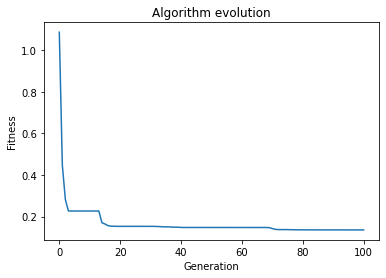

In [17]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.show()
    
VisualizaEvolucion(estimador.best_outputs)

### Evaluación del clasificador (red neuronal) en stratified k-fold cross-validation

In [18]:
n_splits=5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
resultado = np.sqrt(-cross_val_score(estimador, X=X, y=y, scoring='neg_mean_squared_error', cv=cv))
print('(%d)-fold RMSE = ' % n_splits, resultado)
print('(%d)-fold ACC mean (std) = %s (%s)' % (n_splits, str(resultado.mean()), str(resultado.std())))

Generation: 100 Fitness (MSE): 0.11095104687028073 RMSE: 0.33309315044035465: : 101it [00:06, 16.22it/s]
Generation: 100 Fitness (MSE): 0.17946148958347588 RMSE: 0.42362895272098183: : 101it [00:06, 16.49it/s]
Generation: 100 Fitness (MSE): 0.15929587669114464 RMSE: 0.3991188753882039: : 101it [00:06, 16.44it/s]
Generation: 100 Fitness (MSE): 0.1848340321811654 RMSE: 0.4299232863909158: : 101it [00:06, 16.31it/s]
Generation: 100 Fitness (MSE): 0.10523655398292875 RMSE: 0.32440184028905994: : 101it [00:06, 16.42it/s]

(5)-fold RMSE =  [1.27662535 0.07840587 0.30254333 1.13371544 0.62977508]
(5)-fold ACC mean (std) = 0.6842130149843719 (0.4623077601535747)


### Evaluación del clasificador (red neuronal) en repeated stratified k-fold cross-validation

In [19]:
n_splits=5
n_repeats=2
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
resultado = np.sqrt(-cross_val_score(estimador, X=X, y=y, scoring='neg_mean_squared_error', cv=cv))
print('(%d)-fold repeat %d - RMSE mean (std) = ' % (n_splits, n_repeats), resultado)
print('(%d)-fold repeat %d - RMSE mean (std) = %s (%s)' % (n_splits, n_repeats, str(resultado.mean()), str(resultado.std())))

Generation: 100 Fitness (MSE): 0.11095104687028073 RMSE: 0.33309315044035465: : 101it [00:06, 16.43it/s]
Generation: 100 Fitness (MSE): 0.17946148958347588 RMSE: 0.42362895272098183: : 101it [00:06, 16.52it/s]
Generation: 100 Fitness (MSE): 0.15929587669114464 RMSE: 0.3991188753882039: : 101it [00:06, 16.51it/s]
Generation: 100 Fitness (MSE): 0.1848340321811654 RMSE: 0.4299232863909158: : 101it [00:06, 16.48it/s]
Generation: 100 Fitness (MSE): 0.10523655398292875 RMSE: 0.32440184028905994: : 101it [00:06, 16.53it/s]
Generation: 100 Fitness (MSE): 0.18483618506108435 RMSE: 0.42992579017905447: : 101it [00:06, 16.53it/s]
Generation: 100 Fitness (MSE): 0.10815849416934045 RMSE: 0.3288745872963438: : 101it [00:06, 16.53it/s]
Generation: 100 Fitness (MSE): 0.13437581873916757 RMSE: 0.366573074214634: : 101it [00:06, 16.50it/s]
Generation: 100 Fitness (MSE): 0.13740358881106143 RMSE: 0.37067990073790275: : 101it [00:06, 16.55it/s]
Generation: 100 Fitness (MSE): 0.15408811725629662 RMSE: 0.39

(5)-fold repeat 2 - RMSE mean (std) =  [1.27662535 0.07840587 0.30254333 1.13371544 0.62977508 0.60317157
 0.48916355 0.59263876 0.34827909 0.43375666]
(5)-fold repeat 2 - RMSE mean (std) = 0.5888074704438153 (0.3473036120169623)
